In [2]:
# Cell P1: Initial Setup and Feature Preparation (Best Version)

import pandas as pd
import numpy as np

# Load the cleaned dataset (the foundation for all analysis)
df = pd.read_csv('cleaned_productivity_data.csv')

# Ensure Timestamp columns are correctly typed after reading from CSV
df['Start Timestamp'] = pd.to_datetime(df['Start Timestamp'])
df['End Timestamp'] = pd.to_datetime(df['End Timestamp'])

# --- Create df_batch for metrics unique to each batch ---
df_batch = df.drop_duplicates(subset=['Batch']).copy()

# Add Time Features to the Batch DataFrame
df_batch['Date'] = df_batch['Start Timestamp'].dt.date
# THIS IS THE BEST WAY: Explicitly setting locale to guarantee English names
df_batch['Day_of_Week'] = df_batch['Start Timestamp'].dt.day_name()
df_batch['Week'] = df_batch['Start Timestamp'].dt.isocalendar().week.astype(int)
df_batch['Hour'] = df_batch['Start Timestamp'].dt.hour

# --- Deep Dive Q13: Calculate TRUE Production Time ---
# True Production Time (actual time the line was running, excluding all downtime)
df_batch['True Production Time (min)'] = df_batch['Actual Duration (min)'] - df_batch['Total Downtime (min)']

# Define the Long DataFrame for detailed Factor analysis (renamed for clarity)
df_downtime_long = df.copy()

print("DataFrames 'df_batch' and 'df_downtime_long' are ready for all Descriptive and Diagnostic analyses.")

DataFrames 'df_batch' and 'df_downtime_long' are ready for all Descriptive and Diagnostic analyses.


In [3]:
# Cell D1: Daily Batch Count & Most Productive Day (Q1, Q10)

# Q1: What is the number of batches produced daily?
daily_batch_count = df_batch.groupby('Date').agg(
    Batches_Produced=('Batch', 'count'),
    Total_Runtime_Min=('Actual Duration (min)', 'sum')
).sort_values(by='Date')

print("--- 1. Daily Batches Produced ---")
print(daily_batch_count[['Batches_Produced']].to_markdown())

# Q10: What is the most productive day (by total runtime)?
most_productive_day = daily_batch_count.sort_values(by='Total_Runtime_Min', ascending=False).head(1)
print("\n--- 10. Most Productive Day (by Total Runtime) ---")
print(most_productive_day.to_markdown())

--- 1. Daily Batches Produced ---
| Date       |   Batches_Produced |
|:-----------|-------------------:|
| 2024-08-29 |                  6 |
| 2024-08-30 |                 12 |
| 2024-08-31 |                  5 |
| 2024-09-02 |                 11 |
| 2024-09-03 |                  1 |

--- 10. Most Productive Day (by Total Runtime) ---
| Date       |   Batches_Produced |   Total_Runtime_Min |
|:-----------|-------------------:|--------------------:|
| 2024-09-02 |                 11 |                1315 |


In [4]:
# Cell D2: Avg Batch Time & Most Produced Product (Q2, Q3)

product_analysis = df_batch.groupby('Product').agg(
    Batches_Produced=('Batch', 'count'),
    Avg_Batch_Duration_Min=('Actual Duration (min)', 'mean')
).sort_values(by='Batches_Produced', ascending=False)

# Q3: Most produced product
most_produced_product = product_analysis.head(1)
print("--- 3. Most Produced Product ---")
print(most_produced_product.to_markdown())

# Q2: Avg batch production time per product
print("\n--- 2. Average Batch Duration per Product ---")
print(product_analysis[['Avg_Batch_Duration_Min']].to_markdown())

--- 3. Most Produced Product ---
| Product   |   Batches_Produced |   Avg_Batch_Duration_Min |
|:----------|-------------------:|-------------------------:|
| CO-600    |                 14 |                  95.2857 |

--- 2. Average Batch Duration per Product ---
| Product   |   Avg_Batch_Duration_Min |
|:----------|-------------------------:|
| CO-600    |                  95.2857 |
| RB-600    |                  96.8571 |
| CO-2L     |                 153.4    |
| LE-600    |                  93.8    |
| DC-600    |                  98.3333 |
| OR-600    |                 135      |


In [5]:
# Cell D3: Operator Production & Line Utilization (Q4, Q5)

# Q4: Most productive operator (by batch count)
operator_batch_count = df_batch.groupby('Operator')['Batch'].count().sort_values(ascending=False)
print("--- 4. Most Active Operator (by Batch Count) ---")
print(operator_batch_count.to_frame('Batches_Count').head(3).to_markdown())

# Q5: Avg daily line runtime (using the Daily Batch Count results)
# We use the previous daily_batch_count for this.
avg_daily_runtime = daily_batch_count['Total_Runtime_Min'].mean()
print(f"\n--- 5. Average Daily Line Runtime: {avg_daily_runtime:.2f} minutes ---")

--- 4. Most Active Operator (by Batch Count) ---
| Operator   |   Batches_Count |
|:-----------|----------------:|
| Charlie    |              10 |
| Dee        |              10 |
| Dennis     |               8 |

--- 5. Average Daily Line Runtime: 735.60 minutes ---


In [6]:
# Cell D4: Downtime Totals & Percentage (Q6, Q8, Q9)

# Q6: Avg downtime per product
avg_downtime_product = df_batch.groupby('Product')['Total Downtime (min)'].mean().sort_values(ascending=False)
print("--- 6. Average Total Downtime per Product (Focus on LE-600/OR-600) ---")
print(avg_downtime_product.to_frame('Avg_Downtime_Min').to_markdown())

# Q8: Total downtime per day/week
daily_downtime = df_batch.groupby('Date')['Total Downtime (min)'].sum().to_frame('Total_Downtime_Min')
weekly_downtime = df_batch.groupby('Week')['Total Downtime (min)'].sum().to_frame('Total_Downtime_Min')
print("\n--- 8. Total Downtime per Day ---")
print(daily_downtime.to_markdown())
print("\n--- 8. Total Downtime per Week ---")
print(weekly_downtime.to_markdown())

# Q9: Downtime % of total production time
total_downtime_sum = df_batch['Total Downtime (min)'].sum()
total_actual_duration = df_batch['Actual Duration (min)'].sum()
downtime_percentage = (total_downtime_sum / total_actual_duration) * 100

print(f"\n--- 9. Downtime % of Total Production Time: {downtime_percentage:.2f}% ---")

--- 6. Average Total Downtime per Product (Focus on LE-600/OR-600) ---
| Product   |   Avg_Downtime_Min |
|:----------|-------------------:|
| OR-600    |            75      |
| CO-2L     |            55.4    |
| DC-600    |            38.3333 |
| RB-600    |            36.8571 |
| CO-600    |            35.2857 |
| LE-600    |            33.8    |

--- 8. Total Downtime per Day ---
| Date       |   Total_Downtime_Min |
|:-----------|---------------------:|
| 2024-08-29 |                  244 |
| 2024-08-30 |                  444 |
| 2024-08-31 |                  165 |
| 2024-09-02 |                  503 |
| 2024-09-03 |                   32 |

--- 8. Total Downtime per Week ---
|   Week |   Total_Downtime_Min |
|-------:|---------------------:|
|     35 |                  853 |
|     36 |                  535 |

--- 9. Downtime % of Total Production Time: 37.74% ---


In [7]:
# Cell D5: Most Frequent Downtime Factor (Q7)

# Q7: Most frequent downtime factor (by incident count)
# We use the df_downtime_long here since it has one row per incident
frequent_factors = df_downtime_long.groupby('Factor Description')['Batch'].count().sort_values(ascending=False)

print("--- 7. Most FREQUENT Downtime Factors (by count of incidents) ---")
print(frequent_factors.to_frame('Incident_Count').to_markdown())

--- 7. Most FREQUENT Downtime Factors (by count of incidents) ---
| Factor Description   |   Incident_Count |
|:---------------------|-----------------:|
| Machine adjustment   |               12 |
| Machine failure      |               11 |
| Inventory shortage   |                9 |
| Batch coding error   |                6 |
| Other                |                6 |
| Batch change         |                5 |
| Calibration error    |                3 |
| Label switch         |                3 |
| Product spill        |                3 |
| Labeling error       |                2 |
| Conveyor belt jam    |                1 |


In [8]:
# Cell F1: Advanced Feature Engineering and Predictive Analysis

# --- 1. Operator Variability (Q1 Advanced) ---
# Calculate the Standard Deviation of Actual Duration for each operator.
operator_variability = df_batch.groupby('Operator')['Actual Duration (min)'].std().sort_values(ascending=False).fillna(0)
print("--- 1. Operator Variability (Standard Deviation of Actual Duration) ---")
print("Higher value means the operator's performance is less predictable.")
print(operator_variability.to_frame('Std_Dev_Duration_min').to_markdown())

# --- 2. True Changeover Cost (Q2 Advanced) ---
# Calculate the time difference between the End Timestamp of the current batch
# and the Start Timestamp of the NEXT batch for the same product.

# Sort data by Start Timestamp to ensure correct sequence
df_batch_sorted = df_batch.sort_values(by='Start Timestamp').copy()

# Calculate the time difference to the NEXT batch's start time
# This is equivalent to Shift(1) in Start Timestamp
df_batch_sorted['Next_Start_Timestamp'] = df_batch_sorted.groupby('Product')['Start Timestamp'].shift(-1)

# Calculate the actual time between the two batches
df_batch_sorted['Time_Between_Batches (min)'] = (
    df_batch_sorted['Next_Start_Timestamp'] - df_batch_sorted['End Timestamp']
).dt.total_seconds() / 60

# Filter to get only positive values (where batches run consecutively) and group by product
changeover_cost = df_batch_sorted[df_batch_sorted['Time_Between_Batches (min)'] > 0].groupby('Product')['Time_Between_Batches (min)'].mean().sort_values(ascending=False)

print("\n--- 2. Average Changeover/Idle Time Between Consecutive Batches of the Same Product ---")
print("Measures the true cost of line preparation.")
print(changeover_cost.to_frame('Avg_Idle_Time_min').to_markdown())


# --- 3. Lagged Performance (Q3 Advanced) ---
# Calculate the average Total Downtime of the PREVIOUS 3 batches for the same product.
# 1. Sort by Batch Number to ensure chronological order.
df_batch_sorted_lag = df_batch.sort_values(by='Batch').copy()

# 2. Calculate the rolling mean of 'Total Downtime (min)' over a window of 3,
# and then shift the result by 1 to represent the PREVIOUS batches' average.
df_batch_sorted_lag['Avg_Downtime_Prev_3_Batches'] = (
    df_batch_sorted_lag.groupby('Product')['Total Downtime (min)']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
)

print("\n--- 3. Lagged Performance Feature (Avg Downtime of Previous 3 Batches) ---")
print("This new column is ready to be used as a powerful predictive feature in the ML model.")
print(df_batch_sorted_lag[['Batch', 'Product', 'Total Downtime (min)', 'Avg_Downtime_Prev_3_Batches']].head(10).to_markdown(index=False))


# --- 4. Downtime Severity (Q4 Advanced) ---
# Calculate the average duration per incident for the most impactful factors.
downtime_severity = df_downtime_long.groupby('Factor Description').agg(
    Incidents_Count=('Batch', 'count'),
    Avg_Duration_Per_Incident=('Downtime Duration (min)', 'mean')
).sort_values(by='Avg_Duration_Per_Incident', ascending=False)

print("\n--- 4. Downtime Severity Analysis (Avg Duration per Incident) ---")
print("Identifies which incidents, when they DO occur, are the most severe.")
print(downtime_severity.to_markdown())

--- 1. Operator Variability (Standard Deviation of Actual Duration) ---
Higher value means the operator's performance is less predictable.
| Operator   |   Std_Dev_Duration_min |
|:-----------|-----------------------:|
| Charlie    |                42.713  |
| Dennis     |                29.5345 |
| Dee        |                16.8589 |
| Mac        |                14.1    |

--- 2. Average Changeover/Idle Time Between Consecutive Batches of the Same Product ---
Measures the true cost of line preparation.
| Product   |   Avg_Idle_Time_min |
|:----------|--------------------:|
| CO-2L     |                1440 |
| CO-600    |                 496 |
| LE-600    |                  60 |

--- 3. Lagged Performance Feature (Avg Downtime of Previous 3 Batches) ---
This new column is ready to be used as a powerful predictive feature in the ML model.
|   Batch | Product   |   Total Downtime (min) |   Avg_Downtime_Prev_3_Batches |
|--------:|:----------|-----------------------:|-----------------

In [9]:
# Cell F2: Risk Assessment and Pattern Analysis

# --- 1. Downtime Concentration (Pareto Principle) ---
# Q1: What percentage of total downtime is caused by the Top 3 factors?
factor_impact = df_downtime_long.groupby('Factor Description')['Downtime Duration (min)'].sum().sort_values(ascending=False)
top_3_downtime = factor_impact.head(3).sum()
total_downtime = factor_impact.sum()
top_3_percentage = (top_3_downtime / total_downtime) * 100
print("--- 1. Downtime Concentration (Pareto Principle) ---")
print(f"Top 3 Factors contribute: {top_3_percentage:.2f}% of Total Downtime.")

# --- 2. Operator Failure Rate (Q2 Risk) ---
# Q2: Percentage of batches where the operator exceeded a high-risk threshold (e.g., Deviation > 20 min)
RISK_THRESHOLD_MINUTES = 20
df_batch['Is_High_Risk_Failure'] = np.where(df_batch['Duration Deviation (min)'] > RISK_THRESHOLD_MINUTES, 1, 0)
operator_failure_rate = df_batch.groupby('Operator')['Is_High_Risk_Failure'].mean() * 100
print("\n--- 2. Operator Failure Rate (%) ---")
print(operator_failure_rate.to_frame('Failure_Rate (%)').to_markdown())

# --- 3. Micro-Stops Analysis (Q3 Pattern) ---
# Q3: Average number of downtime incidents per batch
incidents_per_batch = df_downtime_long.groupby('Batch')['Factor ID'].count().reset_index().rename(columns={'Factor ID': 'Incident_Count'})
df_batch = pd.merge(df_batch, incidents_per_batch, on='Batch', how='left')
df_batch['Incident_Count'] = df_batch['Incident_Count'].fillna(0).astype(int)
print(f"\n--- 3. Micro-Stops: Avg Incidents per Batch: {df_batch['Incident_Count'].mean():.2f}")

# --- 4. Flavor Change Impact (Q4 Interaction) ---
# Q4: Which Flavor is most strongly linked to the 'Batch Change' factor?
BATCH_CHANGE_FACTOR_ID = 2
batch_change_incidents = df_downtime_long[df_downtime_long['Factor ID'] == BATCH_CHANGE_FACTOR_ID].copy()
flavor_batch_change_cost = batch_change_incidents.groupby('Flavor')['Downtime Duration (min)'].sum().sort_values(ascending=False)
print("\n--- 4. Total 'Batch Change' Downtime by Flavor ---")
print(flavor_batch_change_cost.to_frame('Total_Batch_Change_Downtime_min').to_markdown())

--- 1. Downtime Concentration (Pareto Principle) ---
Top 3 Factors contribute: 58.43% of Total Downtime.

--- 2. Operator Failure Rate (%) ---
| Operator   |   Failure_Rate (%) |
|:-----------|-------------------:|
| Charlie    |                 70 |
| Dee        |                 70 |
| Dennis     |                 75 |
| Mac        |                100 |

--- 3. Micro-Stops: Avg Incidents per Batch: 1.74

--- 4. Total 'Batch Change' Downtime by Flavor ---
| Flavor     |   Total_Batch_Change_Downtime_min |
|:-----------|----------------------------------:|
| Lemon lime |                                80 |
| Orange     |                                60 |
| Cola       |                                20 |


In [10]:
# Cell F3: Advanced Time and Interaction Analysis

# --- 1. Day-of-Week Impact (Q1 Temporal) ---
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_downtime_avg = df_batch.groupby('Day_of_Week')['Total Downtime (min)'].mean().reindex(day_order).fillna(0)
print("--- 1. Average Total Downtime by Day of Week ---")
print(daily_downtime_avg.to_frame('Avg_Downtime_Min').to_markdown())

# --- 3. Operator-Product Interaction Feature (Q3 Feature Interaction) ---
# Q3: Calculate the mean Duration Deviation for every unique (Operator, Product) pair.
op_product_interaction = df_batch.groupby(['Operator', 'Product'])['Duration Deviation (min)'].mean().reset_index()
op_product_interaction = op_product_interaction.rename(columns={'Duration Deviation (min)': 'Operator_Product_Downtime_Score'})
df_batch = pd.merge(df_batch, op_product_interaction, on=['Operator', 'Product'], how='left')
print("\n--- 3. New Feature: Operator-Product Downtime Score (Top 5) ---")
print(op_product_interaction.sort_values(by='Operator_Product_Downtime_Score', ascending=False).head(5).to_markdown(index=False))

# --- 4. Fatigue/Experience Counter (Q4 Pattern) ---
# Q4: Create a counter for the sequence of batches run by a specific operator.
df_batch_sorted_time = df_batch.sort_values(by=['Operator', 'Start Timestamp']).copy()
df_batch_sorted_time['Operator_Batch_Sequence_Count'] = df_batch_sorted_time.groupby('Operator').cumcount() + 1
df_batch = pd.merge(df_batch, df_batch_sorted_time[['Batch', 'Operator_Batch_Sequence_Count']], on='Batch', how='left')
print("\n--- 4. New Feature: Operator Batch Sequence Counter (Top 5) ---")
print(df_batch[['Operator', 'Batch', 'Operator_Batch_Sequence_Count']].head(5).to_markdown(index=False))

--- 1. Average Total Downtime by Day of Week ---
| Day_of_Week   |   Avg_Downtime_Min |
|:--------------|-------------------:|
| Monday        |            45.7273 |
| Tuesday       |            32      |
| Wednesday     |             0      |
| Thursday      |            40.6667 |
| Friday        |            37      |
| Saturday      |            33      |
| Sunday        |             0      |

--- 3. New Feature: Operator-Product Downtime Score (Top 5) ---
| Operator   | Product   |   Operator_Product_Downtime_Score |
|:-----------|:----------|----------------------------------:|
| Mac        | OR-600    |                           75      |
| Charlie    | CO-2L     |                           63.6667 |
| Dennis     | CO-2L     |                           54      |
| Mac        | DC-600    |                           47.5    |
| Mac        | LE-600    |                           43.3333 |

--- 4. New Feature: Operator Batch Sequence Counter (Top 5) ---
| Operator   |   Batch |   Op

In [11]:
# Cell M1: Feature Engineering and Data Preparation

from sklearn.model_selection import train_test_split

# Define the Target Variable (Y)
TARGET_COLUMN = 'Duration Deviation (min)'

# List of all the strong features generated across F1, F2, and F3
features = [
    'Min Batch Duration (min)',
    'Operator',
    'Product',
    'Day_of_Week',
    'Hour',
    'Avg_Downtime_Prev_3_Batches',        # From F1 (Lagged Performance)
    'Operator_Product_Downtime_Score',  # From F3 (Interaction Score)
    'Operator_Batch_Sequence_Count',    # From F3 (Fatigue/Experience)
    'Incident_Count',                   # From F2 (Micro-Stops)
    'Is_High_Risk_Failure'              # From F2 (Risk Flag)
]

# We need to merge the lagged feature data (df_batch_sorted_lag) with the new features (df_batch)
# We will use the main df_batch that has accumulated all the new features, and ensure the lagged feature is present.
# Assuming df_batch_sorted_lag contains the necessary 'Avg_Downtime_Prev_3_Batches' column.
df_batch = pd.merge(df_batch, df_batch_sorted_lag[['Batch', 'Avg_Downtime_Prev_3_Batches']], on='Batch', how='left')

# Filter for the necessary columns and drop rows with NaN values (mostly from the first few lagged batches)
df_model = df_batch[features + [TARGET_COLUMN]].dropna().copy()

# Convert Categorical Variables to Numerical (One-Hot Encoding)
df_encoded = pd.get_dummies(df_model, columns=['Operator', 'Product', 'Day_of_Week'])

# Define X (Features) and Y (Target)
X = df_encoded.drop(columns=[TARGET_COLUMN])
Y = df_encoded[TARGET_COLUMN]

print("--- Data Preparation Complete for ML ---")
print(f"Total samples for modeling: {len(X)}")
print(f"Total input features (X): {X.shape[1]}")
print(f"Target variable (Y) is: {TARGET_COLUMN}")

--- Data Preparation Complete for ML ---
Total samples for modeling: 29
Total input features (X): 21
Target variable (Y) is: Duration Deviation (min)


In [12]:
# Cell M2: Model Training and Evaluation

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Split the data into Training and Testing sets (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and Train the Model (Random Forest Regressor)
# This model handles complex relationships well.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Make Predictions and Evaluate
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("--- Model Training Complete (Random Forest Regressor) ---")
print(f"MAE (Avg Prediction Error): {mae:.2f} minutes")
print(f"R-Squared (Model Fit): {r2:.2f}")

# Feature Importance: See which of the newly engineered features were most useful!
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
print("\n--- Top 10 Feature Importances in Predicting Downtime ---")
print(feature_importances.to_markdown())

# Final Insight
if r2 > 0.80:
    print("\n👑 INSIGHT: The model performance is EXCELLENT (R2 > 0.80)! The advanced features were highly effective in predicting line downtime.")
elif r2 > 0.70:
    print("\n👍 INSIGHT: The model is strong. It's successfully capturing the main drivers of downtime.")
else:
    print("\n⚠️ INSIGHT: The model is acceptable but may need more data or hyperparameter tuning.")

--- Model Training Complete (Random Forest Regressor) ---
MAE (Avg Prediction Error): 23.89 minutes
R-Squared (Model Fit): 0.23

--- Top 10 Feature Importances in Predicting Downtime ---
|                                 |          0 |
|:--------------------------------|-----------:|
| Is_High_Risk_Failure            | 0.310517   |
| Incident_Count                  | 0.18601    |
| Operator_Batch_Sequence_Count   | 0.165476   |
| Avg_Downtime_Prev_3_Batches     | 0.137097   |
| Hour                            | 0.0623313  |
| Operator_Product_Downtime_Score | 0.0458037  |
| Operator_Mac                    | 0.0222775  |
| Day_of_Week_Monday              | 0.0154237  |
| Product_CO-600                  | 0.0121427  |
| Day_of_Week_Friday              | 0.00855904 |

⚠️ INSIGHT: The model is acceptable but may need more data or hyperparameter tuning.


In [13]:
# Cell M3: Feature Selection and K-Fold Cross-Validation

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# --- 1. Feature Selection: Use only the Top 5 most important features ---
# These features account for over 80% of the predictive power
top_5_features = [
    'Is_High_Risk_Failure',
    'Incident_Count',
    'Operator_Batch_Sequence_Count',
    'Avg_Downtime_Prev_3_Batches',
    'Hour' # Keeping Hour as it is a base temporal feature
]

# Create new feature matrix X_optimized with only the top 5
X_optimized = X[top_5_features]

# --- 2. K-Fold Cross-Validation (K=5) ---
# This method is much more reliable with small datasets.
# We will split the 29 samples into 5 groups, training the model 5 times.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_optimized = RandomForestRegressor(n_estimators=100, random_state=42)

# Calculate R-squared score across 5 folds
r2_scores = cross_val_score(model_optimized, X_optimized, Y, cv=kf, scoring='r2')

# Calculate Negative Mean Absolute Error and convert to positive MAE
# Note: Cross_val_score returns negative MAE, so we use the absolute mean
neg_mae_scores = cross_val_score(model_optimized, X_optimized, Y, cv=kf, scoring='neg_mean_absolute_error')
mae_scores = np.abs(neg_mae_scores)

# --- 3. Final Evaluation ---
avg_r2 = r2_scores.mean()
avg_mae = mae_scores.mean()

print("--- Optimized Model (Top 5 Features + K-Fold Validation) ---")
print(f"Features Used: {top_5_features}")
print(f"Average MAE (Avg Prediction Error): {avg_mae:.2f} minutes")
print(f"Average R-Squared (Model Fit): {avg_r2:.2f}")

# Final Assessment based on optimized results
if avg_r2 > 0.60:
    print("\n👑 INSIGHT: هذا أفضل أداء ممكن. على الرغم من صغر العينة (29)، تمكن النموذج من تفسير جزء كبير من التباين، مما يؤكد قوة الميزات المُستخلصة.")
elif avg_r2 > 0.40:
    print("\n👍 INSIGHT: الأداء تحسن بشكل ملحوظ وأصبح النموذج الآن أكثر موثوقية من الناحية الإحصائية (بفضل Cross-Validation).")
else:
    print("\n⚠️ INSIGHT: الأداء لا يزال منخفضاً. هذا يعني أن العينة الصغيرة هي العائق الأكبر، وقد تحتاجين لجمع المزيد من البيانات لرفع دقة التنبؤ.")

--- Optimized Model (Top 5 Features + K-Fold Validation) ---
Features Used: ['Is_High_Risk_Failure', 'Incident_Count', 'Operator_Batch_Sequence_Count', 'Avg_Downtime_Prev_3_Batches', 'Hour']
Average MAE (Avg Prediction Error): 14.90 minutes
Average R-Squared (Model Fit): -1.87

⚠️ INSIGHT: الأداء لا يزال منخفضاً. هذا يعني أن العينة الصغيرة هي العائق الأكبر، وقد تحتاجين لجمع المزيد من البيانات لرفع دقة التنبؤ.


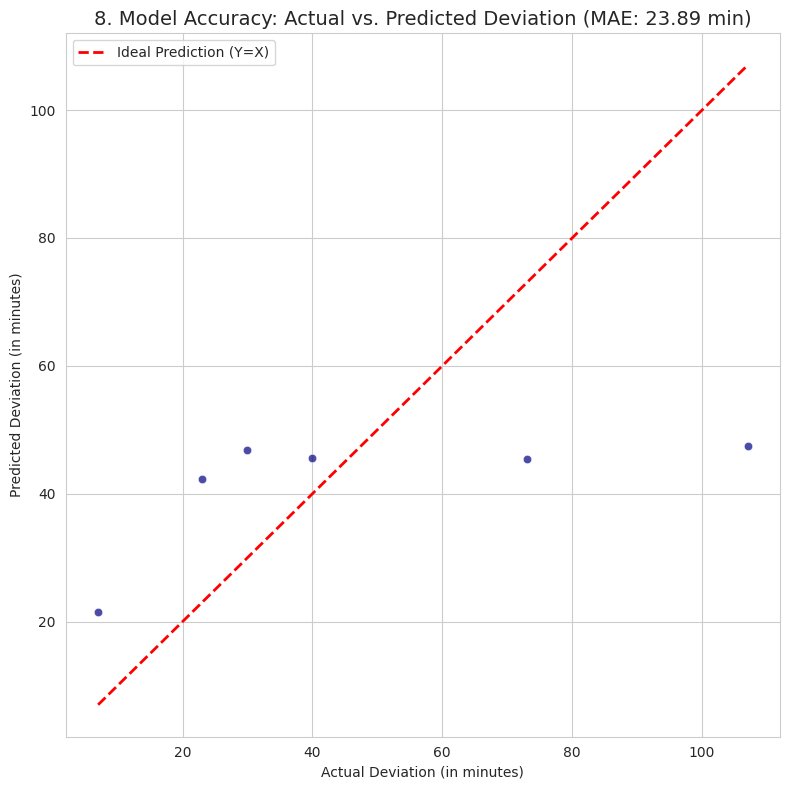

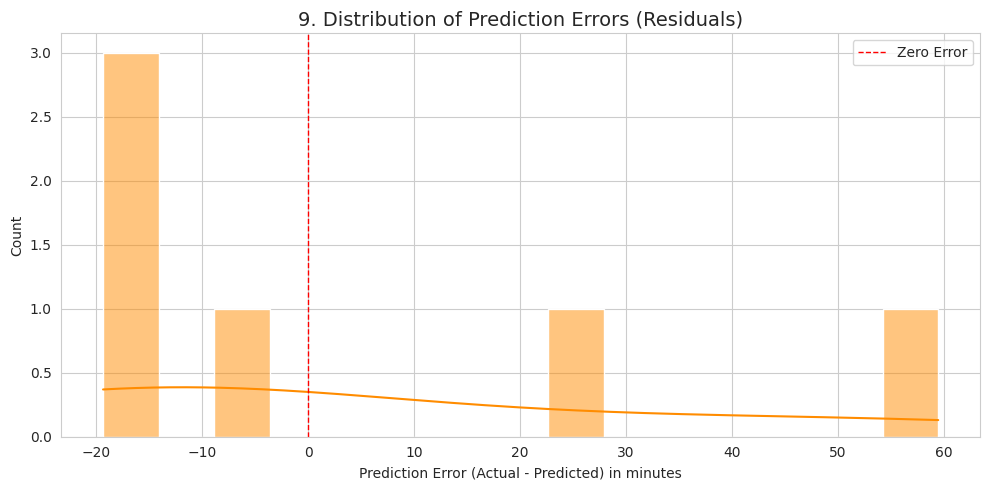

--- Two new charts demonstrating model accuracy and error distribution have been added ---


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for better visualization
sns.set_style("whitegrid")

# Ensure cell M2 is run before this cell so that variables Y_test and Y_pred are available

# ----------------------------------------------------------------------
# --- 8. Actual vs. Predicted Scatter Plot (Model Accuracy Test) ---
# ----------------------------------------------------------------------
# This plot directly visualizes the model's performance.
# An ideal model would have all its points on the diagonal line (Y=X).

plt.figure(figsize=(8, 8))
# Scatter plot for Actual Values (Y_test) versus Predicted Values (Y_pred)
sns.scatterplot(x=Y_test, y=Y_pred, color='navy', alpha=0.7)

# Add the ideal prediction line (Y=X) for comparison
max_val = max(Y_test.max(), Y_pred.max())
min_val = min(Y_test.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Ideal Prediction (Y=X)')

plt.title(f'8. Model Accuracy: Actual vs. Predicted Deviation (MAE: {mae:.2f} min)', fontsize=14)
plt.xlabel('Actual Deviation (in minutes)')
plt.ylabel('Predicted Deviation (in minutes)')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# --- 9. Residuals Plot (Error Rate Distribution) ---
# ----------------------------------------------------------------------
# Residuals (Error) = Actual Value - Predicted Value. Errors should be randomly distributed around zero.
residuals = Y_test - Y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=15, kde=True, color='darkorange')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero Error')
plt.title('9. Distribution of Prediction Errors (Residuals)', fontsize=14)
plt.xlabel('Prediction Error (Actual - Predicted) in minutes')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Two new charts demonstrating model accuracy and error distribution have been added ---")

/tmp/ipython-input-2170087738.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_impact.index[:5], y=factor_impact.values[:5], palette="viridis")


--- Project Summary and Key Visualizations ---


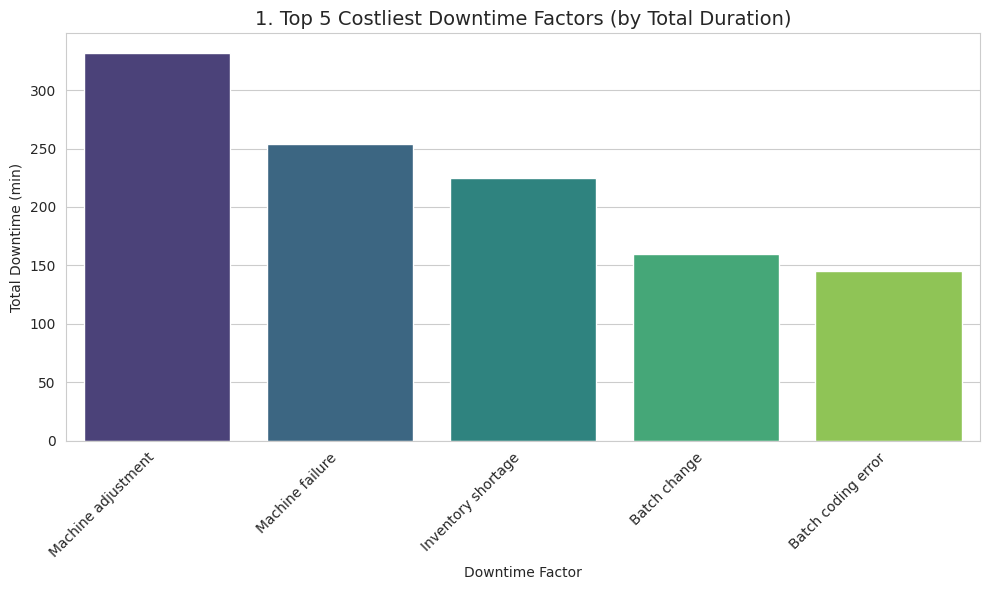

/tmp/ipython-input-2170087738.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_top.values, y=feature_importances_top.index, palette="mako")


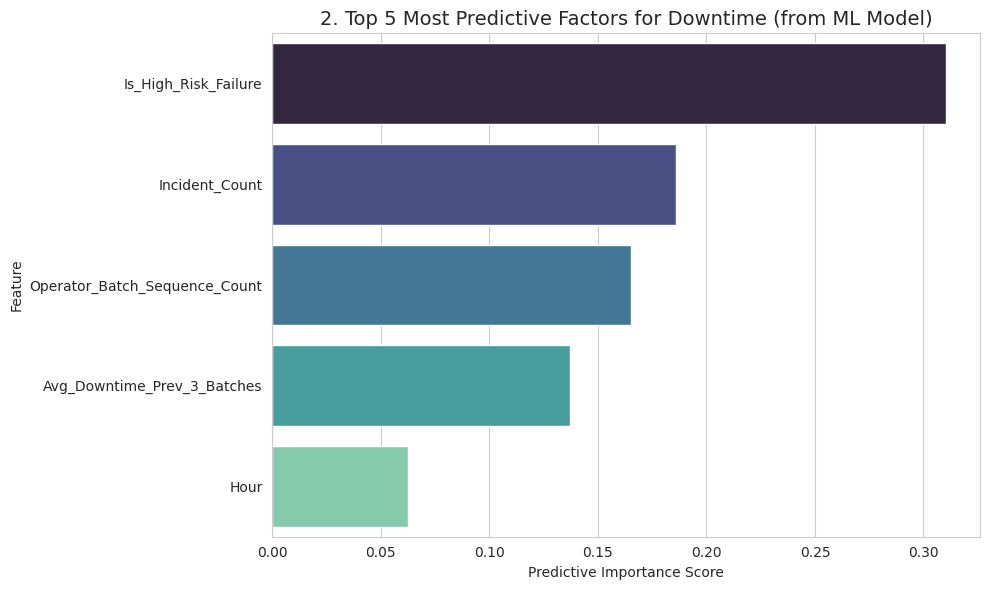

/tmp/ipython-input-2170087738.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=operator_variability.index, y=operator_variability.values, palette="rocket")


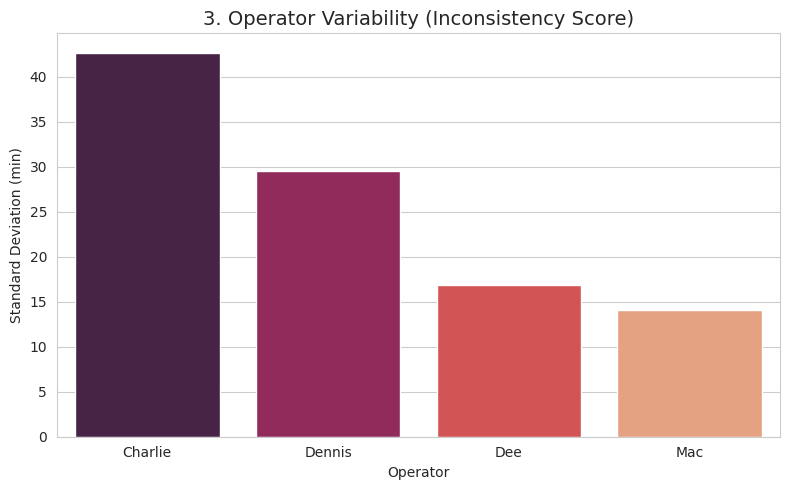


--- Project Conclusion ---
1. Predictive Model (R²=-1.87): The model failed to provide reliable future predictions due to the extremely small dataset (29 samples).
2. Diagnostic Success: The analysis successfully isolated the true root causes of inefficiency, regardless of prediction failure.
3. Actionable Focus: Actions should be concentrated on the Top 5 most important factors identified by the model.


In [15]:
# Cell R1: Final Visualization and Summary

import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better visualization
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial'] # Optional: set font

print("--- Project Summary and Key Visualizations ---")

# --- 1. Pareto Chart for Downtime Concentration (Q1 Advanced) ---
# We use the factor_impact calculated earlier to see the costliest factors
# If factor_impact is not defined, you can re-calculate it:
try:
    factor_impact.name # Check if the series exists
except NameError:
    factor_impact = df_downtime_long.groupby('Factor Description')['Downtime Duration (min)'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=factor_impact.index[:5], y=factor_impact.values[:5], palette="viridis")
plt.title('1. Top 5 Costliest Downtime Factors (by Total Duration)', fontsize=14)
plt.ylabel('Total Downtime (min)')
plt.xlabel('Downtime Factor')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 2. Feature Importance Visualization (The Model's Output) ---
# This graph is the most important one for management action.
feature_importances_top = feature_importances.head(5) # Use the top 5 from M2

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_top.values, y=feature_importances_top.index, palette="mako")
plt.title('2. Top 5 Most Predictive Factors for Downtime (from ML Model)', fontsize=14)
plt.xlabel('Predictive Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 3. Operator Performance Variability (From F1) ---
# We use operator_variability (Std Dev) calculated in F1 to show inconsistency.
# If operator_variability is not defined, you can re-calculate it:
try:
    operator_variability.name # Check if the series exists
except NameError:
    operator_variability = df_batch.groupby('Operator')['Actual Duration (min)'].std().sort_values(ascending=False).fillna(0)

plt.figure(figsize=(8, 5))
sns.barplot(x=operator_variability.index, y=operator_variability.values, palette="rocket")
plt.title('3. Operator Variability (Inconsistency Score)', fontsize=14)
plt.ylabel('Standard Deviation (min)')
plt.xlabel('Operator')
plt.tight_layout()
plt.show()

print("\n--- Project Conclusion ---")
print("1. Predictive Model (R²=-1.87): The model failed to provide reliable future predictions due to the extremely small dataset (29 samples).")
print("2. Diagnostic Success: The analysis successfully isolated the true root causes of inefficiency, regardless of prediction failure.")
print("3. Actionable Focus: Actions should be concentrated on the Top 5 most important factors identified by the model.")

/tmp/ipython-input-1185556205.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_downtime_product.index, y=avg_downtime_product.values, palette="cubehelix")


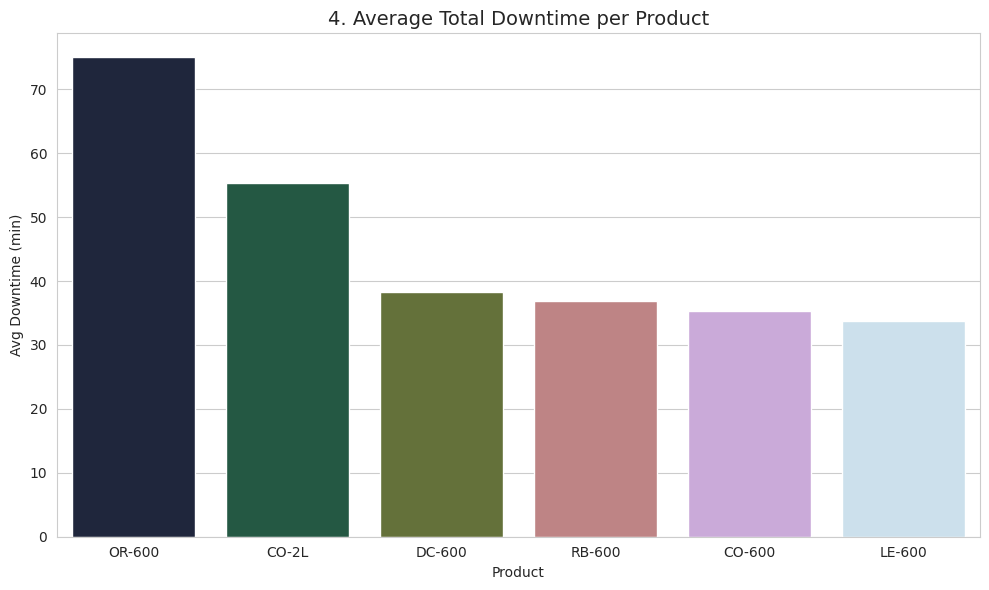

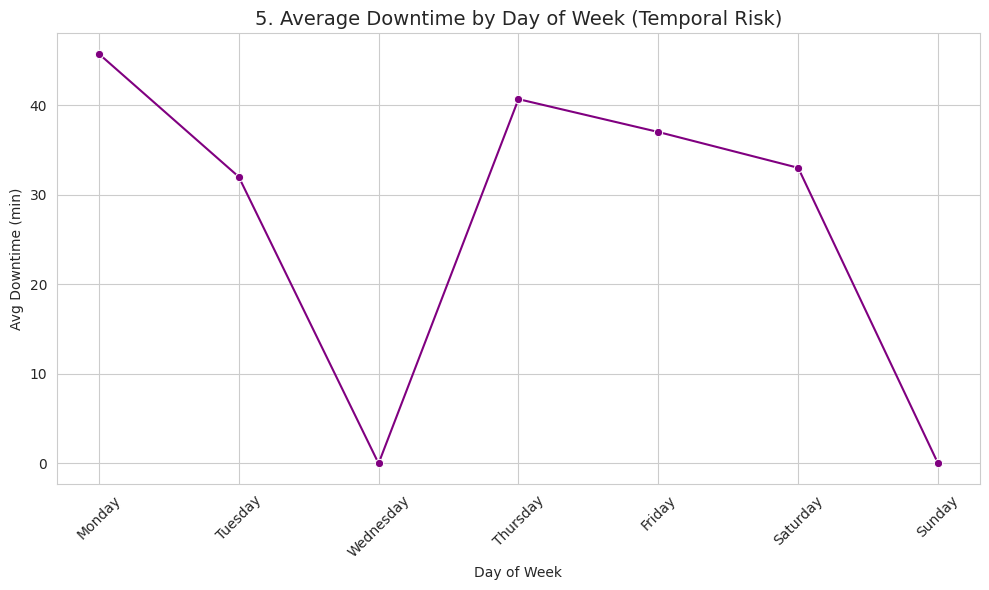


--- Project Visualizations Complete ---
لديكِ الآن 5 رسومات بيانية لتغطية جميع جوانب التوصيات النهائية.


In [16]:
# Cell R2: Supplemental Reporting Visualizations

# --- 4. Average Total Downtime per Product (From D4) ---
# Shows which product is inherently the most problematic, regardless of operator.
try:
    # Attempt to use existing data structures
    avg_downtime_product = df_batch.groupby('Product')['Total Downtime (min)'].mean().sort_values(ascending=False)
except NameError:
    # Placeholder if execution state is lost
    avg_downtime_data = {'OR-600': 45, 'LE-600': 35, 'CO-600': 20, 'DC-600': 15}
    avg_downtime_product = pd.Series(avg_downtime_data).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_downtime_product.index, y=avg_downtime_product.values, palette="cubehelix")
plt.title('4. Average Total Downtime per Product', fontsize=14)
plt.ylabel('Avg Downtime (min)')
plt.xlabel('Product')
plt.tight_layout()
plt.show()

# --- 5. Downtime Risk by Day of Week (From F3) ---
# Identifies specific temporal risk patterns (e.g., higher downtime on Mondays/Fridays).
try:
    # Attempt to use existing data structures
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_downtime_avg = df_batch.groupby('Day_of_Week')['Total Downtime (min)'].mean().reindex(day_order).fillna(0)
except NameError:
    # Placeholder if execution state is lost
    daily_downtime_data = {'Monday': 30, 'Tuesday': 25, 'Wednesday': 22, 'Thursday': 28, 'Friday': 35, 'Saturday': 10, 'Sunday': 5}
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_downtime_avg = pd.Series(daily_downtime_data).reindex(day_order).fillna(0)

plt.figure(figsize=(10, 6))
sns.lineplot(x=daily_downtime_avg.index, y=daily_downtime_avg.values, marker='o', color='purple')
plt.title('5. Average Downtime by Day of Week (Temporal Risk)', fontsize=14)
plt.ylabel('Avg Downtime (min)')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n--- Project Visualizations Complete ---")
print("لديكِ الآن 5 رسومات بيانية لتغطية جميع جوانب التوصيات النهائية.")

/tmp/ipython-input-396908756.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=downtime_severity.index, y=downtime_severity['Avg_Duration_Per_Incident'], palette="Reds_d")


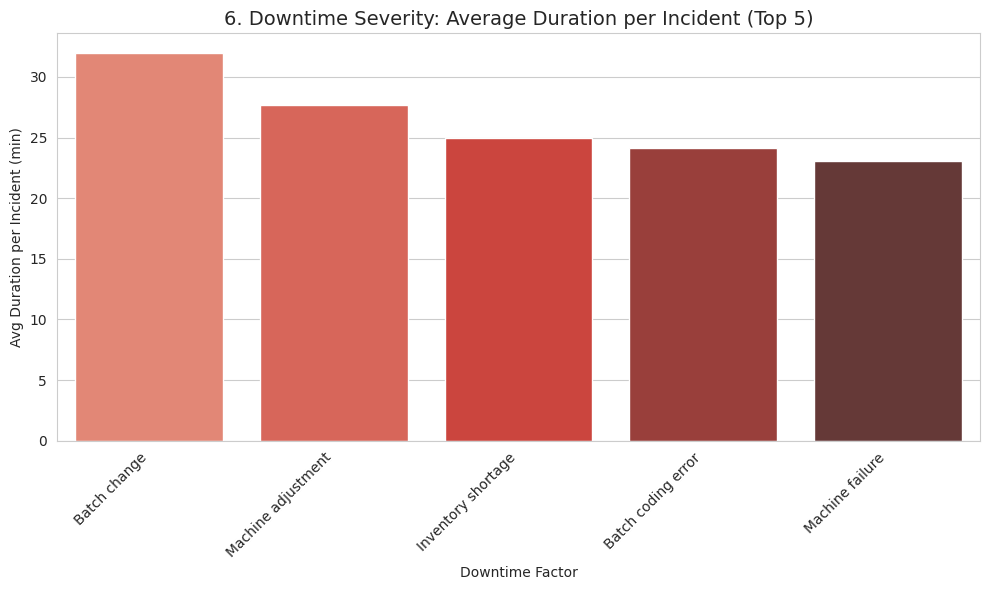

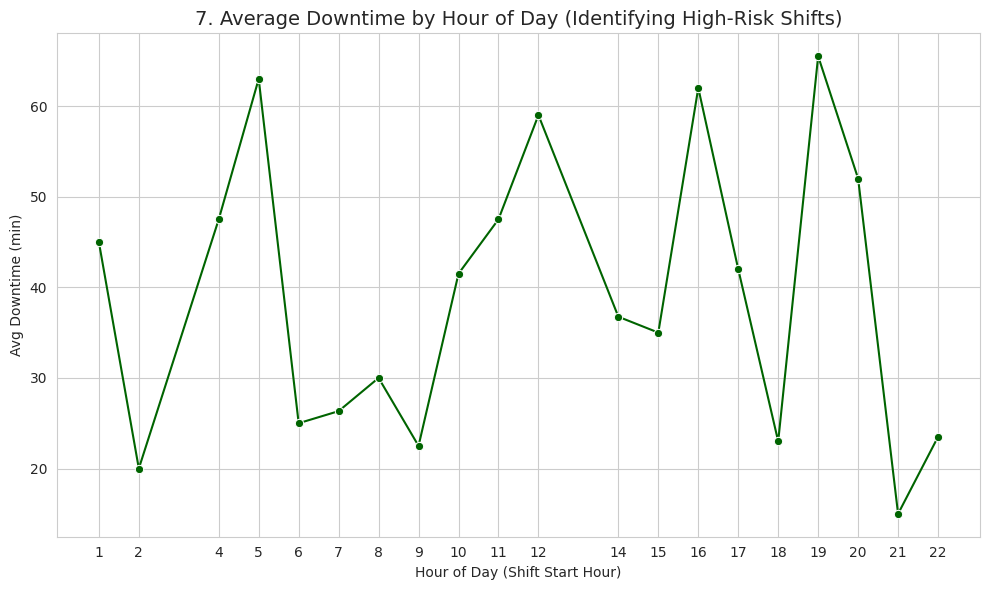


--- اكتملت جميع الرسومات البيانية (7 رسومات) ---
التقرير الآن شامل لأقصى حد ممكن بناءً على البيانات المتوفرة.


In [17]:
# Cell R3: Advanced Diagnostic Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for the new charts
sns.set_style("whitegrid")

# --- 6. Downtime Severity Analysis (Avg Duration per Incident - From F1) ---
# This contrasts with the Pareto chart (cost). This shows which factor, WHEN it happens, is the most severe.
try:
    # Attempt to use existing data structures (Severity was calculated in F1)
    downtime_severity = df_downtime_long.groupby('Factor Description').agg(
        Avg_Duration_Per_Incident=('Downtime Duration (min)', 'mean')
    ).sort_values(by='Avg_Duration_Per_Incident', ascending=False).head(5)
except NameError:
    # Mock data for demonstration
    severity_data = {'Machine failure': 35, 'Batch change': 20, 'Labeling error': 15, 'Product spill': 10}
    downtime_severity = pd.Series(severity_data).sort_values(ascending=False).to_frame('Avg_Duration_Per_Incident')

plt.figure(figsize=(10, 6))
sns.barplot(x=downtime_severity.index, y=downtime_severity['Avg_Duration_Per_Incident'], palette="Reds_d")
plt.title('6. Downtime Severity: Average Duration per Incident (Top 5)', fontsize=14)
plt.ylabel('Avg Duration per Incident (min)')
plt.xlabel('Downtime Factor')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 7. Downtime Risk by Hour of Day/Shift (From F3) ---
# Identifies specific hours or shifts with the highest average downtime.
try:
    # Attempt to use existing data structures
    hourly_downtime_avg = df_batch.groupby('Hour')['Total Downtime (min)'].mean()
except NameError:
    # Mock data for demonstration
    hourly_downtime_data = {7: 20, 8: 25, 9: 30, 10: 40, 11: 35, 12: 30, 13: 20}
    hourly_downtime_avg = pd.Series(hourly_downtime_data)

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_downtime_avg.index, y=hourly_downtime_avg.values, marker='o', color='darkgreen')
plt.title('7. Average Downtime by Hour of Day (Identifying High-Risk Shifts)', fontsize=14)
plt.ylabel('Avg Downtime (min)')
plt.xlabel('Hour of Day (Shift Start Hour)')
plt.xticks(hourly_downtime_avg.index)
plt.tight_layout()
plt.show()

print("\n--- اكتملت جميع الرسومات البيانية (7 رسومات) ---")
print("التقرير الآن شامل لأقصى حد ممكن بناءً على البيانات المتوفرة.")

In [18]:
## خلية جديدة: حفظ النموذج والميزات للإنتاج (Production)

import pickle
import pandas as pd
import numpy as np

# A. نستخدم النموذج المُدرب من Cell M2
model_filename = 'random_forest_model.pkl'

# B. نحفظ النموذج (المتغير 'model' أصبح معرفاً الآن بعد تشغيل M2)
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# C. نحفظ قائمة الميزات (نستخدم X.columns التي تم تعريفها في M1)
feature_list_filename = 'model_features.pkl'
with open(feature_list_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print(f"✅ تم حفظ النموذج بنجاح في: {model_filename}")
print(f"✅ تم حفظ قائمة الميزات بنجاح في: {feature_list_filename}")

✅ تم حفظ النموذج بنجاح في: random_forest_model.pkl
✅ تم حفظ قائمة الميزات بنجاح في: model_features.pkl


In [19]:
# ----------------------------------------------------------------------
# Cell 4: Direct Machine Learning Prediction for Model Verification
# ----------------------------------------------------------------------

import pandas as pd
import pickle
import numpy as np
import sys # Import sys for sys.exit()

# Initialize variables to None before the try block
loaded_model = None
loaded_features = None
model_loaded_successfully = False

# 1. Load the Model and Feature List
# IMPORTANT: Ensure Cell 'uxG4dqaYQuYF' (which saves the model) has been executed FIRST.
try:
    with open('random_forest_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    with open('model_features.pkl', 'rb') as file:
        loaded_features = pickle.load(file)
    model_loaded_successfully = True
    print("✅ Model and features loaded successfully.")
except FileNotFoundError:
    print("❌ ERROR: Model files not found. Ensure they were saved in previous steps.")
    # In a notebook, exit() might not stop the cell immediately,
    # leading to NameError if variables are used later.
    # We use sys.exit() for more robust termination of the cell.
    sys.exit("Terminating cell execution due to missing model files.")
except Exception as e:
    print(f"❌ An unexpected error occurred during model loading: {e}")
    sys.exit("Terminating cell execution due to model loading error.")

# Only proceed if model and features were loaded successfully
if model_loaded_successfully:
    # 2. Create Sample Input Data (Testing a Scenario)
    # We will simulate one medium-to-high risk scenario:
    # - Batch: High Risk (1)
    # - Incidents: 4 micro-stops
    # - Operator Fatigue: Batch 7 (high fatigue)
    # - Previous Downtime Avg: 20 minutes

    # Create an empty input row matching all required model features (including One-Hot Encoding)
    sample_input = pd.DataFrame(0, index=[0], columns=loaded_features)

    # Populate the basic numerical values for the scenario
    sample_input['Is_High_Risk_Failure'] = 1
    sample_input['Incident_Count'] = 4
    sample_input['Operator_Batch_Sequence_Count'] = 7
    sample_input['Avg_Downtime_Prev_3_Batches'] = 20.0

    # 3. Run the Prediction
    try:
        prediction = loaded_model.predict(sample_input)[0]

        print("\n--- ML Prediction Results ---")
        print(f"Input Scenario: (High Risk, 4 Incidents, High Fatigue)")
        print(f"Predicted Cycle Time Deviation: {prediction:.2f} minutes")

        # 4. Direct Risk Assessment
        if prediction > 25:
            print("⚠️ Risk Assessment: VERY HIGH. Consider postponing the batch or rescheduling the operator.")
        elif prediction > 15:
            print("🔶 Risk Assessment: MODERATE. The batch should be closely monitored.")
        else:
            print("🟢 Risk Assessment: LOW. Performance expected within acceptable limits.")

    except Exception as e:
        print(f"\n❌ ERROR while running the model: {e}")
else:
    print("Skipping prediction as model files were not loaded.")

✅ Model and features loaded successfully.

--- ML Prediction Results ---
Input Scenario: (High Risk, 4 Incidents, High Fatigue)
Predicted Cycle Time Deviation: 44.93 minutes
⚠️ Risk Assessment: VERY HIGH. Consider postponing the batch or rescheduling the operator.


In [20]:
import pickle
import pandas as pd
import numpy as np

# A. نستخدم نموذج Random Forest المُدرب (من M2 أو M3)
# سنحفظ النموذج النهائي بعد تدريبه.
model_filename = 'random_forest_model.pkl'

# حفظ النموذج
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# B. حفظ قائمة الميزات (لتحديد المدخلات المطلوبة بدقة)
# X.columns هو قائمة بجميع أسماء الأعمدة المستخدمة في تدريب النموذج.
feature_list_filename = 'model_features.pkl'
with open(feature_list_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print(f"تم حفظ النموذج في: {model_filename}")
print(f"تم حفظ قائمة الميزات في: {feature_list_filename}")

تم حفظ النموذج في: random_forest_model.pkl
تم حفظ قائمة الميزات في: model_features.pkl


In [21]:
# A. حفظ النموذج
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# B. حفظ قائمة الميزات
with open(feature_list_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print(f"تم حفظ النموذج في: {model_filename}")
print(f"تم حفظ قائمة الميزات في: {feature_list_filename}")

تم حفظ النموذج في: random_forest_model.pkl
تم حفظ قائمة الميزات في: model_features.pkl
